In [57]:
import pandas as pd
import pandahouse as ph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statistics
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import requests

In [58]:
groups=pd.read_csv('./data/groups.csv',sep=';')
groups_add=pd.read_csv('./data/groups_add.csv')
active_studs=pd.read_csv('./data/active_studs.csv')
checks=pd.read_csv('./data/checks.csv',sep=';')

# Проект 2
# 1. A/B–тестирование

# 1.1 Анализируем полученные данные

In [59]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [60]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [61]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [62]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [63]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [64]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [65]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [66]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


В представленных 4 датафреймах удовлетворяющий нас тип данных и отсутствуют пропущенные значения.

In [67]:
# проверяем, есть ли в датафрейме пользователи с несколькими покупками, таких нет
checks.groupby('student_id').value_counts().reset_index().rename(columns={0:'count'}).query('count > 1')

,student_id,rev,count


In [68]:
# объединяем 2 датафрейма с группами пользователей
all_groups=pd.concat([groups, groups_add]).reset_index().drop(columns=['index']).rename(columns={'id': 'student_id'})
all_groups

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [69]:
# дополняем датафрейм с группами пользователей информацией о покупках
groups_checks=all_groups.merge(checks, how='left', on='student_id')
groups_checks['rev'] = groups_checks['rev'].replace(np.nan, 0)
groups_checks

,student_id,grp,rev
0,1489,B,0.0
1,1627,A,990.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0
...,...,...,...
74571,200247820,B,0.0
74572,201032527,B,0.0
74573,201067612,B,0.0
74574,201067653,B,0.0


In [70]:
# создаем столбец 'active' со значением 'yes' , чтобы перед добавлением в основной датафрейм пользователей можно было 
# поделить на активных и неактивных
active_studs['active']='yes'
active_studs

,student_id,active
0,581585,yes
1,5723133,yes
2,3276743,yes
3,4238589,yes
4,4475369,yes
...,...,...
8336,1794344,yes
8337,296883,yes
8338,3598448,yes
8339,3610547,yes


In [71]:
# формируем полный датафрейм с данными о пользователях, тестовой группе, покупках, активности, 
# в столбце 'active' указываем значение 'no' у неактивных пользователей
groups_checks_full=groups_checks.merge(active_studs, how='left', on='student_id')
groups_checks_full['active'] = groups_checks_full['active'].replace(np.nan, 'no')
groups_checks_full

,student_id,grp,rev,active
0,1489,B,0.0,no
1,1627,A,990.0,yes
2,1768,B,0.0,no
3,1783,B,0.0,no
4,1794,A,0.0,no
...,...,...,...,...
74571,200247820,B,0.0,no
74572,201032527,B,0.0,no
74573,201067612,B,0.0,no
74574,201067653,B,0.0,no


In [72]:
# выясним, есть ли пользователи, не заходившие на платформу, но выполнившие оплату заказа
groups_checks_full.query("active=='no'").query('rev>0').groupby('grp', as_index=False).student_id.count()

,grp,student_id
0,A,29
1,B,120


In [73]:
# сколько всего пользователей по группам выполнивших оплату заказа
groups_checks_full.query('rev>0').groupby('grp', as_index=False).student_id.count()

,grp,student_id
0,A,107
1,B,434


 В наших данных 149 пользователей (29 из контрольной и 120 из тестовой групп) не заходили на платформу, но, у которых выполнен заказ, что составляет 149/541 *100 = 27.5% от платящих пользователей. Можно предположить, что 
у данных пользователей оформлена подписка и списание произошло автоматически, либо пользователь был авторизован
на платформе и факт входа на платформу не записался в данных, либо по технической причине информация по входу на
платформу была утеряна или не формировалась должным образом.

In [74]:
# оценим какие это суммы покупок и сколько раз встречаются
groups_checks_full.query("active=='no'").query('rev>0').rev.value_counts()

690.0000     61
290.0000     24
990.0000     19
1140.0000    14
199.0000     14
580.0000      4
1900.0000     4
840.0000      3
398.0000      2
630.0000      1
1980.0000     1
1180.0000     1
1900.0001     1
Name: rev, dtype: int64

Так как суммы оплат сильно варьируются, маловероятно, что причина кроется исключительно в автоматическом списании оплаты за подписку. Также выяснилось, что доля таких данных от общего числа покупок достаточно высока: 27.5%. Поэтому я бы не хотела удалять эти данные. Единственно, что смущает единичная сумма заказа "1900.0001". Посмотрим есть ли подобные заказы среди активных пользователей.

In [75]:
# суммы заказов активных пользователей
groups_checks_full.query("active=='yes'").rev.value_counts()

0.0000       7949
1900.0000      93
290.0000       70
1900.0001      35
199.0000       32
840.0000       24
990.0000       22
690.0000       17
1140.0000      11
580.0000       11
590.0000       11
1530.0000       8
398.0000        7
870.0000        6
3660.0000       5
2910.0000       4
2890.0000       4
489.0000        3
1160.0000       3
1980.0000       3
2099.0000       3
2820.0000       2
2220.0000       2
3260.0000       1
597.0000        1
1339.0000       1
1180.0000       1
1968.0000       1
1050.0000       1
1830.0000       1
1388.0000       1
2900.0000       1
1729.0000       1
2190.0000       1
4650.0000       1
796.0000        1
3040.0000       1
880.0000        1
1039.0000       1
Name: rev, dtype: int64

Суммы заказов "1900.0001" среди активных пользователей встречаются 35 раз, так что оставим эти суммы.

In [76]:
# не попавшие в раздел активных, но с оплаченым заказом
lost=groups_checks_full.query("active=='no'").query('rev>0')

In [77]:
# активные пользователи
active=groups_checks_full.query("active=='yes'")

In [78]:
# объединяем активных и не попавших в раздел активных
full_active_users=pd.concat([active,lost]).reset_index().drop(columns=['index'])
full_active_users

,student_id,grp,rev,active
0,1627,A,990.0,yes
1,2085,B,0.0,yes
2,2215,B,0.0,yes
3,3391,A,0.0,yes
4,3401,B,0.0,yes
...,...,...,...,...
8485,5291900,B,199.0,no
8486,5331842,B,290.0,no
8487,5486319,B,199.0,no
8488,5562806,B,398.0,no


На данном этапе мы получили полный датафрейм с данными, посмотрим на него подробнее

In [79]:
# суммы заказов из группы "А"
full_active_users.query("grp == 'A'").rev.value_counts()

0.0       1460
290.0       31
690.0       19
199.0        7
990.0        6
580.0        6
590.0        5
1140.0       5
3660.0       3
840.0        3
1530.0       3
489.0        2
398.0        2
1160.0       2
1980.0       2
2820.0       2
2910.0       2
2900.0       1
1830.0       1
2220.0       1
1180.0       1
2890.0       1
1039.0       1
870.0        1
Name: rev, dtype: int64

In [80]:
full_active_users.query("grp == 'A'").rev.describe()

count    1567.000000
mean       58.772176
std       303.678591
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [81]:
# суммы заказов из группы "В"
full_active_users.query("grp == 'B'").rev.value_counts()

0.0000       6489
1900.0000      97
290.0000       63
690.0000       59
199.0000       39
1900.0001      36
990.0000       35
840.0000       24
1140.0000      20
580.0000        9
398.0000        7
590.0000        6
1530.0000       5
870.0000        5
2890.0000       3
2099.0000       3
3660.0000       2
1980.0000       2
2910.0000       2
1050.0000       1
1160.0000       1
489.0000        1
597.0000        1
1339.0000       1
630.0000        1
1968.0000       1
3040.0000       1
2220.0000       1
1388.0000       1
1729.0000       1
2190.0000       1
4650.0000       1
796.0000        1
880.0000        1
3260.0000       1
1180.0000       1
Name: rev, dtype: int64

In [82]:
full_active_users.query("grp == 'B'").rev.describe()

count    6923.000000
mean       69.511773
std       326.618480
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

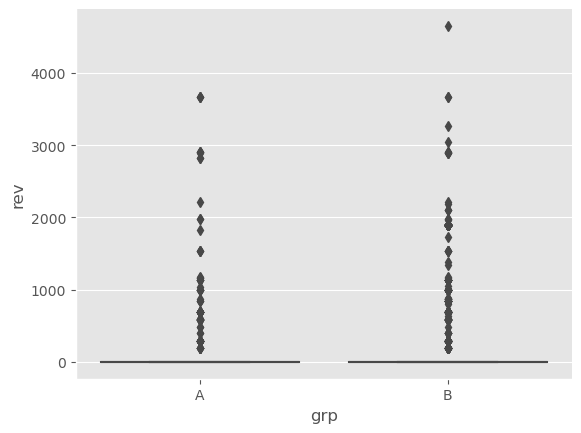

In [83]:
# Распределение заказов всех пользователей по группам
sns.boxplot(data=full_active_users, y='rev', x='grp')
sns.despine()

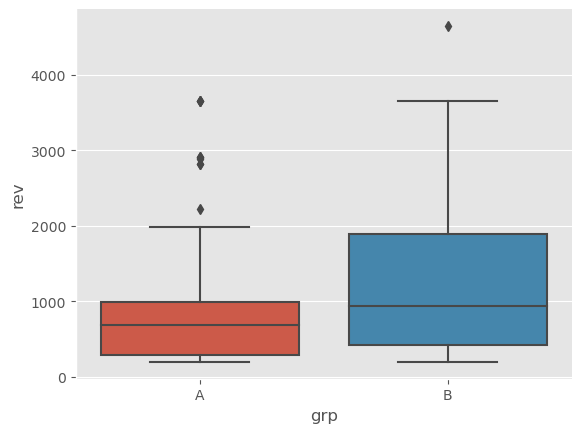

In [84]:
# Распределение заказов оплативших пользователей по группам
sns.boxplot(data=full_active_users.query('rev>0'), y='rev', x='grp')
sns.despine()

По полученным данным видно, что средний чек заказов в тестовой группе возрос. Для получения более точной картины ситуации посчитаем метрики.

# 1.2 Расчитываем необходимые метрики: 
ARPАU, ARPPU, CR в покупку
- ARPAU (Average Revenue Per Active User) - средний платеж на всех активных пользователей
- ARPPU (Average Revenue Per Paying User) - средний платеж на всех платящих пользователей
- CR в покупку активных пользователей - доля пользователей совершивших покупку ко всем активным пользователям

In [85]:
# для облегчения подсчета формул запишем некоторые части расчета в переменные
A_users_w_revenue=full_active_users.query("grp == 'A'").query('rev>0')
B_users_w_revenue=full_active_users.query("grp == 'B'").query('rev>0')
A_users_count=full_active_users.query("grp == 'A'").student_id.count()
B_users_count=full_active_users.query("grp == 'B'").student_id.count()

In [86]:
# расчитываем метрики для контрольной и тестовых групп
Revenue_A=(A_users_w_revenue.agg({'rev':sum})).rev
Revenue_B=(B_users_w_revenue.agg({'rev':sum})).rev
ARPAU_A=Revenue_A/A_users_count
ARPAU_B=Revenue_B/B_users_count
ARPPU_A=Revenue_A/A_users_w_revenue.student_id.count()
ARPPU_B=Revenue_B/B_users_w_revenue.student_id.count()
CR_buy_A=A_users_w_revenue.student_id.count()/A_users_count
CR_buy_B=B_users_w_revenue.student_id.count()/B_users_count

In [87]:
# создадим результирующий датафрейм с метриками
metrics=full_active_users.groupby('grp').student_id.count().reset_index().rename(columns={'student_id':'count'})
metrics['ARPAU']=[ARPAU_A, ARPAU_B]
metrics['ARPPU']=[ARPPU_A, ARPPU_B]
metrics['CR_buy']=[CR_buy_A, CR_buy_B]
metrics['Revenue']=[Revenue_A, Revenue_B]
metrics.round(4)

,grp,count,ARPAU,ARPPU,CR_buy,Revenue
0,A,1567,58.7722,860.7103,0.0683,92096.0000
1,B,6923,69.5118,1108.8249,0.0627,481230.0036


# Вывод: 
Revenue, ARPАU и ARPPU в тестовой группе по отношению к контрольной возросли, а CR в покупку в тестовой группе наоборот стал ниже. Получается, что стали покупать реже, но сумма чека возросла. Для подтверждения или опровержения этой теории проведем А/В - тестирование.

# 1.3 Приступаем к А/B - тестированию

Посмотрим на наши выборки

<AxesSubplot:xlabel='rev', ylabel='Count'>

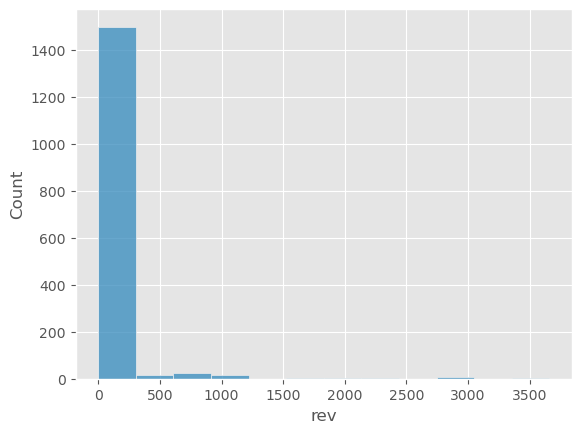

In [88]:
# группа "А" активных пользователей
sns.histplot(data=full_active_users.query("grp == 'A'"), x='rev')

<AxesSubplot:xlabel='rev', ylabel='Count'>

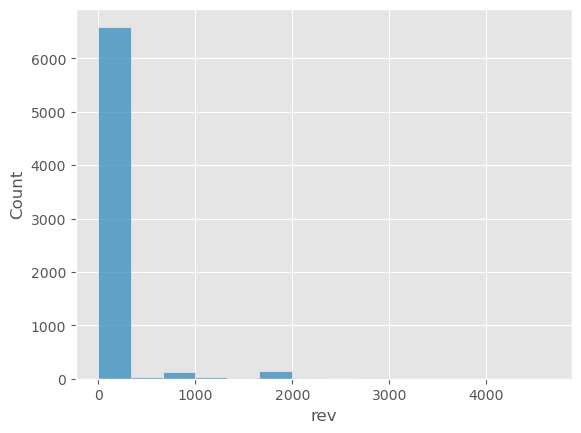

In [89]:
# группа "В" активных пользователей
sns.histplot(data=full_active_users.query("grp == 'B'"), x='rev')

<AxesSubplot:xlabel='rev', ylabel='Count'>

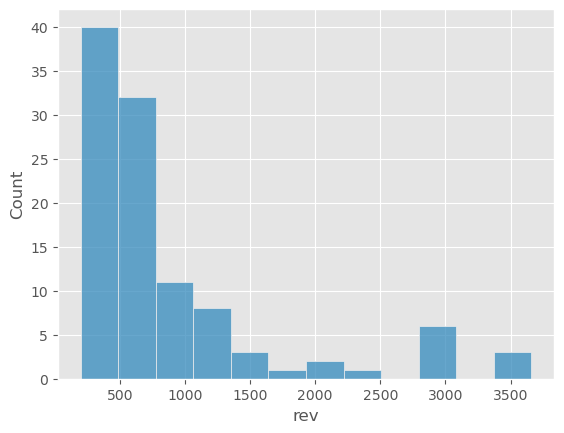

In [90]:
# группа "А", выполнивших оплату, пользователей
sns.histplot(data=full_active_users.query("grp == 'A'").query("rev>0"), x='rev')

<AxesSubplot:xlabel='rev', ylabel='Count'>

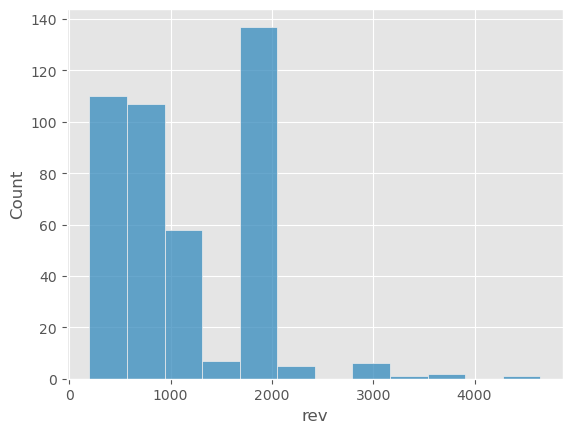

In [91]:
# группа "В", выполнивших оплату, пользователей
sns.histplot(data=full_active_users.query("grp == 'B'").query("rev>0"), x='rev')

Распределение в обеих группах активных пользователей большей частью выборки концентрируется на отметке "0", далее в правой части графика визуализируется остальная часть выборки, составляющая менее 10% от общей выборки. 

Распределения, выполнивших заказ, пользователей в группе "А" ассиметричное, скошено вправо, распределение в группе "В" ассиметричное, можно сказать, что скошено вправо. 

Все эти графики показывают нам ненормальное распределение, поэтому для проведения А/В - тестирования рекомендовано опираться на результаты непараметрических методов.

# Проведем анализ ARPAU

Сформируем гипотезы:
- Но - статистической разницы в ARPAU между выборками нет
- Н1 - по ARPAU выборки статистически различаются

1. Тест Манна -Уитни:

In [92]:
stats.mannwhitneyu(full_active_users[full_active_users.grp == 'A'].rev, 
                   full_active_users[full_active_users.grp == 'B'].rev,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=5449155.0, pvalue=0.5005924615057726)

По результату теста Манна- Уитни, pvalue=0.5005 достаточно высокий, это говорит о том, что зона перекрещивающихся значений между ранжированными значениями рядов экспериментальных групп достаточно велика и мы не можем отклонить нулевую гипотезу.

2. Проведем Bootstrap - тест

In [93]:
def get_bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
   
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='-')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

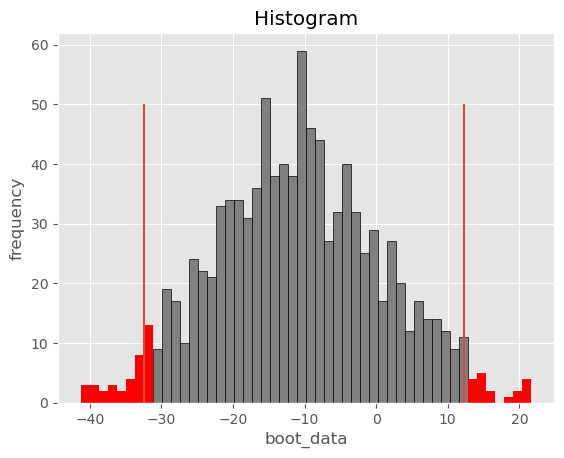

In [94]:
# помещаем наши выборки в функцию Bootstrap
bootstrap=get_bootstrap(full_active_users[full_active_users.grp == 'A'].rev, 
                   full_active_users[full_active_users.grp == 'B'].rev)

In [95]:
bootstrap["p_value"]

0.3455801825183844

In [96]:
bootstrap["quants"]

,0
0.025,-32.434908
0.975,12.270548


По результатам Bootstrap - теста мы получили высокий p-value: 0.3321 и диаппазон между 2.5 и 95.5 квантилем содержит "0", это нам говорит о том, что мы не можем отклонить нулевую гипотезу, а значим разницы между выборками тест не видит.

# Проведем анализ ARPPU

Сформируем гипотезы:
- Но - статистической разницы в ARPPU между выборками нет
- Н1 - по ARPPU выборки статистически различаются

In [97]:
# создадим датафрейм с активными пользователями, выполнившими покупку
active_pay_users=full_active_users.query("rev>0")[['student_id','grp','rev']].copy()
active_pay_users

,student_id,grp,rev
0,1627,A,990.0000
10,100300,B,990.0000
12,108270,B,290.0000
246,264473,B,1900.0001
279,274352,B,690.0000
...,...,...,...
8485,5291900,B,199.0000
8486,5331842,B,290.0000
8487,5486319,B,199.0000
8488,5562806,B,398.0000


1. Тест Манна -Уитни:

In [98]:
stats.mannwhitneyu(active_pay_users[active_pay_users.grp == 'A'].rev, 
                   active_pay_users[active_pay_users.grp == 'B'].rev,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=17862.0, pvalue=0.00019316054996380152)

По результату теста Манна- Уитни, p-value:0.00019 , это говорит о том, что зона перекрещивающихся значений между ранжированными значениями рядов экспериментальных групп маленькая и мы можем отклонить нулевую гипотезу.

2. Проведем Bootstrap - тест

  0%|          | 0/1000 [00:00<?, ?it/s]

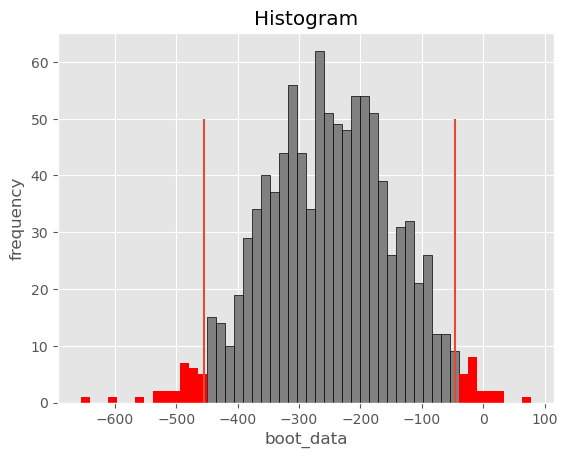

In [99]:
# помещаем наши выборки в функцию Bootstrap (она была объявлена ранее)
bootstrap=get_bootstrap(active_pay_users[active_pay_users.grp == 'A'].rev, 
                   active_pay_users[active_pay_users.grp == 'B'].rev)

In [100]:
bootstrap["p_value"]

0.01866996291714684

In [101]:
bootstrap["quants"]

,0
0.025,-455.416361
0.975,-45.922200


По результатам Bootstrap - теста мы получили небольшой p-value: 0.024 и диаппазон между 2.5 и 95.5 квантилем не содержит "0", это нам говорит о том, что мы можем отклонить нулевую гипотезу, а значит разница между выборками статистически значима

# Проведем анализ CR в покупку

Для оценки критерия CR мы можем использовать критерий Хи-квадрат для сравнения категориональных переменных, то есть факт покупки (была или нет).
Формируем гипотезы:
- Но - CR в контрольной и тестовой группы статистически не отличается
- Н1 - СR в контрольной и тестовой группы статистически отличается

In [102]:
# присвоим категории пользователям
full_active_users['pay']=np.where(full_active_users['rev']>0, 'pay', 'no_pay')

In [103]:
# создадим таблицу сопряженности
pd.crosstab(full_active_users.grp, full_active_users.pay)

pay,no_pay,pay
grp,,
A,1460,107
B,6489,434


In [104]:
# критерий Хи-квадрат
stat, p, dof, expected = stats.chi2_contingency(pd.crosstab(full_active_users.grp, full_active_users.pay))
stat, p

(0.579666003588264, 0.4464432666411111)

Вывод: так как p-value: 0.4464432666411111, что больше 0.05, значит мы не можем отклонить нулевую гипотезу, и CR в контрольной и тестовой группы статистически не отличается.

# Вывод
Результаты тестов:
- CR в покупку: критерий Хи-квадрат: p-value: 0.44644 (не отклоняем Ho)
- ARPAU: 
         - тест Манна-Уитни: p-value: 0.50059 (не отклоняем Ho)
         - Bootstrap-тест: p-value: 0.3455, квантили: 0.025	"-32.434908" | 0.975 "12.270548" (не отклоняем Ho)
- ARPPU: 
         - тест Манна-Уитни: p-value: 0.000193 (отклоняем Ho)
         - Bootstrap-тест: p-value: 0.01866, квантили: 0.025	"-455.416361" | 0.975	"-45.922200" (отклоняем Ho)
         
По результатам тестов можно сделать вывод, что CR и ARPAU статистически значимо не отличаются, новая фича не повлияла на эти показатели. На ARPPU новая фича сработала и при этом улучшила его показатели. Из чего можно сделать вывод, что мы можем выкатить новую фичу на всех пользователях.

# 2. SQL

# 2.1 Очень усердные ученики

Необходимо написать запрос, который даст информацию о количестве очень усердных студентов за текущий месяц (правильно решил 20 задач за текущий месяц)

In [105]:
# задаем параметры для соединения с Clickhouse
connection_default = {'host': '',
                      'database':'default',
                      'user':'', 
                      'password':''
                     }

In [106]:
# формируем запрос о количестве усердных студентов
q= '''select count(st_id) count_students
      from (select st_id
            from default.peas
            where correct = 1 and toStartOfMonth(timest) = toStartOfMonth(today())
            group by st_id
            having count(correct) >=20)
        '''
count_active_students = ph.read_clickhouse(q, connection=connection_default)
count_active_students

,count_students
0,0


Сейчас этот запрос выдает "0" количество студентов, так как за текущий месяц (март 2023) нет данных. Так как в данных есть информация за октябрь 2021, для тестирования запроса установим эту дату.

In [107]:
q_test= '''select count(st_id) count_students
      from (select st_id
            from default.peas
            where correct = 1 and toStartOfMonth(timest) = toStartOfMonth('2021/10/01'::date)
            group by st_id
            having count(correct) >=20)
        '''
count_active_students_test = ph.read_clickhouse(q_test, connection=connection_default)
count_active_students_test

,count_students
0,136


Вывод: Тестовый запрос выдал количество усердных студентов за октябрь 2021: 136 человек.

# 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты. 

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’Math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [108]:
# формируем запрос с данными метрик и групп
query_metrics=  '''with all_studets_by_group as (select test_grp, count(st_id) all_students
                                        from default.studs
                                        group by test_grp),


                    active_studets_by_group as (select test_grp, count(st_id) active_students 
                                                    from
                                                        (select test_grp, st_id
                                                            from default.peas as A
                                                            left join default.studs as B
                                                            on A.st_id=B.st_id
                                                        where correct = 1
                                                        group by test_grp, st_id
                                                        having count(correct) > 10)
                                                    group by test_grp),

                    active_math_studets_by_group as (select test_grp, count(st_id) active_math_students 
                                                        from
                                                            (select test_grp, st_id
                                                                from default.peas as A
                                                                left join default.studs as B
                                                                on A.st_id=B.st_id
                                                            where correct = 1 and subject = 'Math'
                                                            group by test_grp, st_id
                                                            having count(correct) >= 2)
                                                        group by test_grp),

                    all_revenue as (select test_grp, sum(money) revenue
                                                from default.final_project_check as A
                                                left join default.studs as B
                                                on A.st_id=B.st_id
                                            group by test_grp),

                    count_buy as    (select test_grp, count(st_id) count_buy  
                                                from default.final_project_check as A
                                                left join default.studs as B
                                                on A.st_id=B.st_id
                                            group by test_grp),

                    count_buy_math as  (select test_grp, count(st_id) count_buy_math
                                                from default.final_project_check as A
                                                left join default.studs as B
                                                on A.st_id=B.st_id
                                            where subject = 'Math'
                                            group by test_grp)

                    select 
                        (A.test_grp) test_grp,
                        (D.revenue/A.all_students) ARPU,
                        (D.revenue/B.active_students) ARPAU,
                        (E.count_buy/A.all_students) CR_buy,
                        (E.count_buy/B.active_students) CR_active_buy,
                        (F.count_buy_math/C.active_math_students) CR_active_buy_math
                    from all_studets_by_group as A
                    left join active_studets_by_group as B on A.test_grp= B.test_grp
                    left join active_math_studets_by_group as C on A.test_grp= C.test_grp
                    left join all_revenue as D on A.test_grp= D.test_grp
                    left join count_buy as E on A.test_grp= E.test_grp
                    left join count_buy_math as F on A.test_grp= F.test_grp
                    '''

metrics_sql = ph.read_clickhouse(query_metrics, connection=connection_default)
metrics_sql

,test_grp,ARPU,ARPAU,CR_buy,CR_active_buy,CR_active_buy_math
0,control,4540.983607,10905.511811,0.059016,0.141732,0.163265
1,pilot,11508.474576,35364.583333,0.145763,0.447917,0.380952


# Вывод:
Исходя из результатов эксперимента по изменению экрана оплаты в тестовой группе мы получили прирост всех метрик:
- ARPU увеличился в 2.5 раза, 
- ARPPU увеличился в 3.2 раза, 
- CR в покупку увеличился в 2.9 раза, 
- СR активного пользователя в покупку увеличился в 3.1 раз, 
- CR пользователя из активности по математике увеличился в 2.3 раза.

# Задание 3. Python

# 3.1 Реализуйте функцию
Функция будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [109]:
def get_add(groups, groups_add, active_studs, checks):
    """функция get_add принимает 4 файла на вход, в том числе groups_add, который нам необходим.
    
    Функция присваивает названия колонок "groups_add" в соответствии с "groups". 
    Далее объединяются "groups", "groups_add" и "checks", если есть пропущенные значения в суммах оплат, то проставляется "0". 
    Прежде чем добавить файл "active_studs" к датафрейму groups_checks, делается пометка "yes", что пользователи активны.
    Добавляются "active_studs" к "groups_checks", у неактивных пользователей ставится пометка "no". В почти окончательном 
    датафрейме "groups_checks_full" отбираются активные пользователей и неактивные, но у которых прошла оплата.
    Эти группы пользователей соединяются в датафрейм full_active_users, который берется за основу в дальнейшем.
    Далее выполняется расчет метрик.
    """
    groups_add.columns = groups.columns
    all_groups=pd.concat([groups, groups_add]).reset_index().drop(columns=['index']).rename(columns={'id': 'student_id'})
    groups_checks=all_groups.merge(checks, how='left', on='student_id')
    groups_checks['rev'] = groups_checks['rev'].replace(np.nan, 0)
    active_studs['active']='yes'
    groups_checks_full=groups_checks.merge(active_studs, how='left', on='student_id')
    groups_checks_full['active'] = groups_checks_full['active'].replace(np.nan, 'no')
    lost=groups_checks_full.query("active=='no'").query('rev>0')
    active=groups_checks_full.query("active=='yes'")
    full_active_users=pd.concat([active,lost]).reset_index().drop(columns=['index'])
    
    A_users_w_revenue=full_active_users.query("grp == 'A'").query('rev>0')
    B_users_w_revenue=full_active_users.query("grp == 'B'").query('rev>0')
    A_users_count=full_active_users.query("grp == 'A'").student_id.count()
    B_users_count=full_active_users.query("grp == 'B'").student_id.count()
    
    Revenue_A=(A_users_w_revenue.agg({'rev':sum})).rev
    Revenue_B=(B_users_w_revenue.agg({'rev':sum})).rev
    ARPAU_A=Revenue_A/A_users_count
    ARPAU_B=Revenue_B/B_users_count
    ARPPU_A=Revenue_A/A_users_w_revenue.student_id.count()
    ARPPU_B=Revenue_B/B_users_w_revenue.student_id.count()
    CR_buy_A=A_users_w_revenue.student_id.count()/A_users_count
    CR_buy_B=B_users_w_revenue.student_id.count()/B_users_count
 
    
    metrics=full_active_users.groupby('grp').student_id.count().reset_index().rename(columns={'student_id':'count'})
    metrics['ARPAU']=[ARPAU_A, ARPAU_B]
    metrics['ARPPU']=[ARPPU_A, ARPPU_B]
    metrics['CR_buy']=[CR_buy_A, CR_buy_B]
    metrics['Revenue']=[Revenue_A, Revenue_B]
    return metrics.round(4)

In [110]:
get_add(groups, groups_add, active_studs, checks)

,grp,count,ARPAU,ARPPU,CR_buy,Revenue
0,A,1567,58.7722,860.7103,0.0683,92096.0000
1,B,6923,69.5118,1108.8249,0.0627,481230.0036


# 3.2 Реализуйте функцию
Функция будет строить графики по получаемым метрикам.

In [111]:
def get_plots(get_add):
    """функция get_plots визуализирует метрики по группам пользователей"""
    fig, axs = plt.subplots(ncols=4, figsize=(20, 8))
    sns.barplot(x='grp', y='Revenue', data=get_add,ax=axs[0]).set_title('Revenue')
    sns.barplot(x='grp', y='ARPAU', data=get_add,ax=axs[1]).set_title('ARPAU')
    sns.barplot(x='grp', y='ARPPU', data=get_add,ax=axs[2]).set_title('ARPPU')
    sns.barplot(x='grp', y='CR_buy', data=get_add,ax=axs[3]).set_title('CR buy')

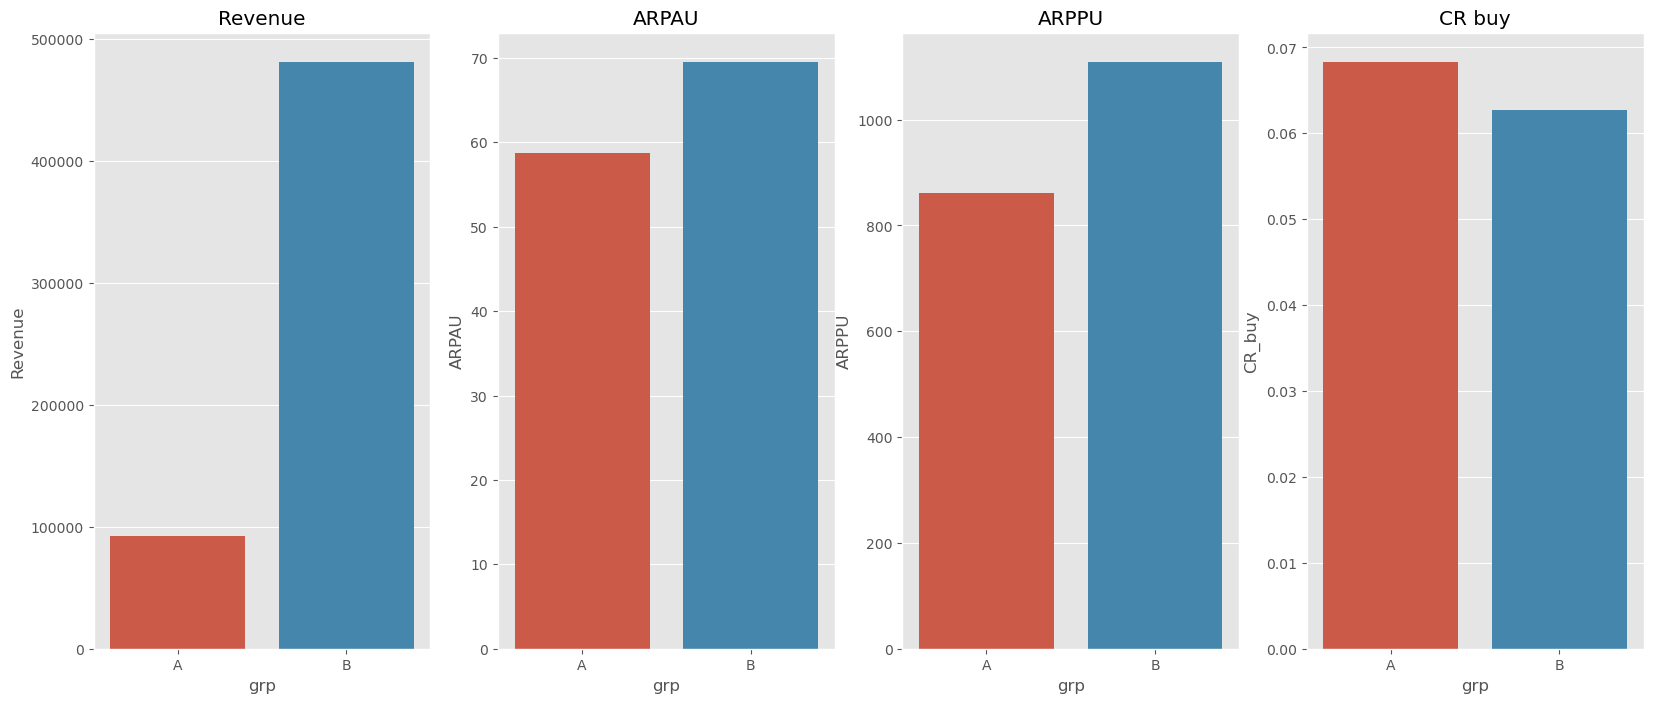

In [112]:
get_plots(get_add(groups, groups_add, active_studs, checks))